# Comparison of Two Service Deployment Patterns

This is a Jupyter notebook.  See http://jupyter.org/ for more information.

## Introduction

Below we compare two service deployment patterns by using discrete-event simulations. Ideally the reader will have had some prior exposure to the Python language in order to follow along all the details.  However, the concepts and conclusions should be understandable to readers with software architecture or engineering background even if not directly familiar with Python.

We assume an application made up of multiple multi-threaded services and consider two deployment patterns:

- **Monolithic deployment**, where all services making up an application are deployed together on each VM or container
- **Microservices deployment**, where each of the services is deployed on its own VM or (more likely) it own container.

In the simulations below, the application is made up of just two services, to simplify the model and the analysis, but without loss of generality in terms of the main conclusions.

The simulation models are written in the **Python** language.  The choice of Python was based not only on Python's rapid development dynamic language characteristics, but also on the availability libraries well-suited for this kind of work:

- **SimPy**, a powerful and easy-to-use simulation framework
- **SciPy**, a powerful set of libraries for efficient data analysis and visualization, including *NumPy*, *Pandas*, and *Matplotlib*.

The simulations here use a small custom framwork named **ServerSim**, based on *SimPy*.


## ServerSim core concepts

ServerSim consists of a several classes and utilities.  The classes relevant to the simulations in this document are described below.

### Server

Represents a server -- physical, VM, or container, with a predetermined computation capacity.  A server can execute arbitrary service request types.  The computation capacity of a server is represented in terms of a number of hardware threads and a total speed number (computation units processed per unit of time).  The total speed is equally apportioned among the hardware threads, to give the speed per hardware thread.  A server also has a number of associated software threads (which must be no smaller than the number of hardware threads).  Software threads are relevant for blocking computations only.

The simulations in this document assume non-blocking services, so the software threads will not be of consequence.

Attributes:
- env: The SimPy Environment (required to run SimPy simulations)
- maxConcurrency: The maximum of number of hardware threads for the server.
- numThreads: The maximum number of software threads for the server.
- speed: Aggregate server speed across all hardware threads.
- name: The server's name.

### SvcRequest

Represents a service request to a server.

    def __init__(self, env, svcName, fgen, server, inVal, inBlockingCall=False):
    Attributes:
        inBlockingCall (bool): Indicates whether this request is
            in the scope of a blocking call.  When this parameter
            is true, the service request will hold a software
            thread on the target server while the service
            request itself and any of its sub-requests (calls
            to other servers) are executing.  Otherwise, the
            call is non-blocking, so a thread is held on the
            target server only while the service request itself
            is executing; the thread is relinquished when
            this request finishes executing and it passes contol
            to its sub-requests.

### SvcRequester

### CoreSvcRequester

### UserGroup

### Other service requester classes

There are other service requester classes (subclasses of SvcRequester) in addition to CoreSvcRequester, to define more complex services, including blocking services, asynchronous fire-and-forget services, sequentially dependednt services, parallel service calls, and service continuations.  These additional classes are not used in the simulations in this document.

## Environment set-up

The code involved in these simulations should be compatible with both Python 2.7 and Python 3.x.

Python
and the following Python packages need to be installed in your computer:
- jupyter-notebook
- simpy
- numpy
- pandas
- matplotlib
- seaborn

If you already have Python and *pip* installed, you can install the above packages with *pip*.  Otherwise, the easiest way to have all of this installed (including Python) is to install [Anaconda](https://www.continuum.io/downloads) or [Miniconda](https://conda.io/miniconda.html).  

Anaconda is a big install that includes all of the above and much more stuff for data science and scientific computing.  Miniconda installs Python and a package manager that makes it easy to install Jupyter Notebook and the other packages with the command:
>`conda install numpy pandas matplotlib seaborn jupyter-notebook`.

The model in this document should be run from the parent directory of the `serversim` package directory, which in turn contains the source files for the ServerSim framework.


## The model


### The core simulation function

Following is the source code for the core function used in the simulations  This function will be called with different arguments to simulate different scenarios.

#### Imports

We start by importing the required libraries, as well as the *__future__* import for compatibility between Python 2.7 and Python 3.x.

#### Parameters:

- *numUsers*: the number of users being simulated.  This parameter can be either a positive integer or a list of pairs.  In the second case, the list of pairs represents a number of users that varies over time as a step function.  The first elements of the pairs in the list must be strictly monotonically increasing and each pair in the list represents a step in the step function.  Each step starts (inclusive) at the time represented by the first component of the corresponding pair and ends (exclusive) at the time represented by the first component of the next pair in the list.
- *weight1*: the relative frequency of service requests for the first service.
- *weight2*: the relative frequency of service requests for the second service.
- *serverRange1*: a Python range representing the numeric server IDs of the servers on which the first service can be deployed.
- *serverRange2*: a Python range representing the numeric server IDs of the servers on which the second service can be deployed.  This and the above range can be overlapping.  In case they are overlapping, the servers in the intersection of the ranges will host both the first and the second service.


In [1]:
# %load deployment_example.py
# We start by importing the required libraries, as well as the __future__
# import for compatibility between Python 2.7 and Python 3.x.

from __future__ import print_function

import random
import simpy
from serversim import *


def deployment_example(numUsers, weight1, weight2, serverRange1, serverRange2):

    def cug(mid, delta):
        """Computation units generator"""
        def f():
            return random.uniform(mid - delta, mid + delta)
        return f

    def ldBal(svcType):
        """Application server load-balancer."""
        if svcType == "svc_1":
            server = random.choice(servers1)
        elif svcType == "svc_2":
            server = random.choice(servers2)
        else:
            assert False, "Invalid service type."
        return server

    # numUsers = 700
    simtime = 200
    hwThreads = 10
    swThreads = 20
    speed = 20
    svc_1_comp_units = 2.0
    svc_2_comp_units = 1.0

    env = simpy.Environment()

    nServers = max(serverRange1[-1]+1, serverRange2[-1]+1)
    servers = [Server(env, hwThreads, swThreads, speed, "AppServer_%s" % i) for i in range(nServers)]
    servers1 = [servers[i] for i in serverRange1]
    servers2 = [servers[i] for i in serverRange2]

    svc_1 = CoreSvcRequester(env, "svc_1", cug(svc_1_comp_units, svc_1_comp_units*.9), ldBal)
    svc_2 = CoreSvcRequester(env, "svc_2", cug(svc_2_comp_units, svc_2_comp_units*.9), ldBal)

    weightedTxns = [(svc_1, weight1),
                    (svc_2, weight2)
                   ]

    minThinkTime = 2.0 # .5 # 4
    maxThinkTime = 10.0 # 1.5 # 20

    grp = UserGroup(env, numUsers, "UserTypeX", weightedTxns, minThinkTime, maxThinkTime)
    grp.activate_users()

    env.run(until=simtime)
    
    return {"num_users":numUsers, "weight1":weight1, "weight2":weight2,
            "serverRange1":serverRange1, "serverRange2":serverRange2, 
            "servers":servers, "grp":grp}

### Printing the simulation results

The following function prints the outputs from the above core simulation function.

In [ ]:
# %load print_results.py
# %%writefile print_results.py
def print_results(numUsers=None, weight1=None, weight2=None, serverRange1=None,
                  serverRange2=None, servers=None, grp=None, fi=None):
    
    if fi is None:
        import sys
        fi = sys.stdout

    print("\n\n***** Start Simulation --", numUsers, ",", weight1, ",", weight2, ", [", serverRange1[0], ",", serverRange1[-1] + 1,
          ") , [", serverRange2[0], ",", serverRange2[-1] + 1, ") *****", file=fi)
    print("Simulation: numUsers =", numUsers, file=fi)

    print("<< ServerExample >>\n", file=fi)

    indent = " " * 4

    print("\n" + "Servers:", file=fi)
    for svr in servers:
        print(indent*1 + "Server:", svr.name, file=fi)
        print(indent*2 + "maxConcurrency =", svr.maxConcurrency, file=fi)
        print(indent*2 + "numThreads =", svr.numThreads, file=fi)
        print(indent*2 + "speed =", svr.speed, file=fi)
        print(indent*2 + "avgProcessTime =", svr.avgProcessTime, file=fi)
        print(indent*2 + "avgHwQueueTime =", svr.avgHwQueueTime, file=fi)
        print(indent*2 + "avgThreadQueueTime =", svr.avgThreadQueueTime, file=fi)
        print(indent*2 + "avgServiceTime =", svr.avgServiceTime, file=fi)
        print(indent*2 + "avgHwQueueLength =", svr.avgHwQueueLength, file=fi)
        print(indent*2 + "avgThreadQueueLength =", svr.avgThreadQueueLength, file=fi)
        print(indent*2 + "hwQueueLength =", svr.hwQueueLength, file=fi)
        print(indent*2 + "hwInProcessCount =", svr.hwInProcessCount, file=fi)
        print(indent*2 + "threadQueueLength =", svr.threadQueueLength, file=fi)
        print(indent*2 + "threadInUseCount =", svr.threadInUseCount, file=fi)
        print(indent*2 + "utilization =", svr.utilization, file=fi)
        print(indent*2 + "throughput =", svr.throughput, file=fi)

    print(indent*1 + "Group:", grp.name, file=fi)
    print(indent*2 + "numUsers =", grp.numUsers, file=fi)
    print(indent*2 + "minThinkTime =", grp.minThinkTime, file=fi)
    print(indent*2 + "maxThinkTime =", grp.maxThinkTime, file=fi)
    print(indent*2 + "respondedRequestCount =", grp.respondedRequestCount(None), file=fi)
    print(indent*2 + "unrespondedRequestCount =", grp.unrespondedRequestCount(None), file=fi)
    print(indent*2 + "avgResponseTime =", grp.avgResponseTime(None), file=fi)
    print(indent*2 + "stdDevResponseTime =", grp.stdDevResponseTime(None), file=fi)
    print(indent*2 + "throughput =", grp.throughput(None), file=fi)

    for txn in grp._txns:
        print(indent*2 + txn.svcName + ":", file=fi)
        print(indent*3 + "respondedRequestCount =", grp.respondedRequestCount(txn), file=fi)
        print(indent*3 + "unrespondedRequestCount =", grp.unrespondedRequestCount(txn), file=fi)
        print(indent*3 + "avgResponseTime =", grp.avgResponseTime(txn), file=fi)
        print(indent*3 + "stdDevResponseTime =", grp.stdDevResponseTime(txn), file=fi)
        print(indent*3 + "throughput =", grp.throughput(txn), file=fi)

In [32]:
# %load server_resp_time.py
from typing import TYPE_CHECKING, Sequence, Tuple
import functools as ft

import numpy as np
from livestats import livestats

if TYPE_CHECKING:
    from serversim import Server


def server_resp_time(time_resolution, servers):
    # type: (float, Sequence[Server]) -> Tuple[Sequence[float], Sequence[float], Sequence[float], Sequence[float]]
    quantiles = [0.5, 0.95, 0.99]

    svc_reqs = []
    for s in servers:
        svc_reqs = svc_reqs + s.svc_req_log

    xys = [(int(svc_req.time_dict["submitted"]/time_resolution),
            svc_req.time_dict["completed"] - svc_req.time_dict["submitted"])
           for svc_req in svc_reqs
           if svc_req.is_completed]

    def ffold(map, p):
        x, y = p
        if x not in map:
            map[x] = livestats.LiveStats(quantiles)
        map[x].add(y)
        return map

    xlvs = ft.reduce(ffold, xys, dict())

    xs = xlvs.keys()
    xs.sort()
    xs = np.array(xs)
    q_50 = np.array([xlvs[x].quantiles()[0] for x in xs])
    q_95 = np.array([xlvs[x].quantiles()[1] for x in xs])
    q_99 = np.array([xlvs[x].quantiles()[2] for x in xs])

    return xs, q_50, q_95, q_99


In [37]:
# %load plot_q50_q95.py
import pylab as plt
from livestats import livestats


def plot_q50_q95(quantiles1, quantiles2):

    X = quantiles1[0]  # should be same as quantiles2[0]
    
    Q1_50 = quantiles1[1]
    Q2_50 = quantiles2[1]

    Q1_95 = quantiles1[2]
    Q2_95 = quantiles2[2]

    plt.plot(X, Q1_50,color='b')
    plt.plot(X, Q1_95,color='c')

    plt.plot(X, Q2_50,color='r')
    plt.plot(X, Q2_95,color='m')

    plt.show()

In [47]:
# %load compare_simulations.py
def compare_simulations(res1, res2):
    servers1 = res1["servers"]
    servers2 = res2["servers"]

    quantiles1 = server_resp_time(5, servers1)
    quantiles2 = server_resp_time(5, servers2)

    plot_q50_q95(quantiles1, quantiles2)

### Output location

We can have the output go to stdout (in this case, the notebook itself) or to a file.  If you want the output to go to a file then modify the first line below (and modify it if you want to use a different file name or location).  Otherwise, comment the first line and uncomment the second line.

In [46]:
fi = open("simout.txt", "w")
# fi = sys.stdout

### Random number generator seed

We set the random number generator seed to have repeatable simulations.  Comment-out this line to have a different system-generated seed everytime the simulations are executed.

In [6]:
random.seed(12345)

### Simulations

Several simulation scenarios are described and executed below.  Certain simulation parameters are varied for each scenario, but there are simulation parameters that are common to all scenarios.

#### Common simulation parameters

The following simulation parameters are common to all the simulations below and are embedded in the core simulation function:

    # numUsers = 700
    simtime = 200
    hwThreads = 10
    swThreads = 20
    speed = 20
    svc_1_comp_units = 2.0
    svc_2_comp_units = 1.0
    minThinkTime = 2.0 # .5 # 4
    maxThinkTime = 10.0 # 1.5 # 20


In [48]:
print("\n\n\n@@@@@@@@@ Start comparative simulations @@@@@@@@@@", file=fi)

#### Simulation 1

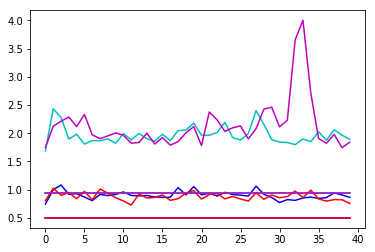

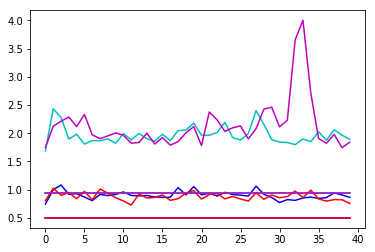

In [52]:
res1 = deployment_example(numUsers=700, weight1=2, weight2=1, serverRange1=range(0, 10),
                          serverRange2=range(0, 10))
res2 = deployment_example(numUsers=700, weight1=2, weight2=1, serverRange1=range(0, 8), 
                          serverRange2=range(8, 10))

# print_results(fi=fi, **res1)
# print_results(fi=fi, **res2)
compare_simulations(res1, res2)
compare_simulations(res1, res2)  # do it again

**conclusions**

#### Simulation 2

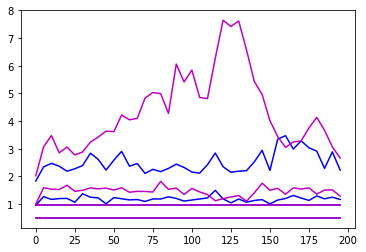

In [88]:
res1 = deployment_example(numUsers=700, weight1=5, weight2=1, serverRange1=range(0, 10),
                          serverRange2=range(0, 10))
res2 = deployment_example(numUsers=700, weight1=5, weight2=1, serverRange1=range(0, 8), 
                          serverRange2=range(8, 10))

# print_results(fi=fi, **res1)
# print_results(fi=fi, **res2)
compare_simulations(res1, res2)

**conclusions**

#### Simulation 3

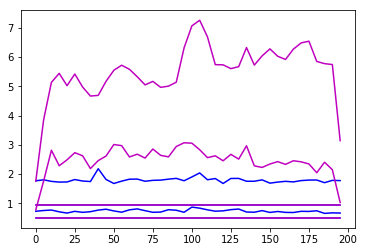

In [89]:
res1 = deployment_example(numUsers=700, weight1=1, weight2=1, serverRange1=range(0, 10), 
                          serverRange2=range(0, 10))
res2 = deployment_example(numUsers=700, weight1=1, weight2=1, serverRange1=range(0, 8), 
                          serverRange2=range(8, 10))

# print_results(fi=fi, **res1)
# print_results(fi=fi, **res2)
compare_simulations(res1, res2)

**conclusions**

#### Simulation 4

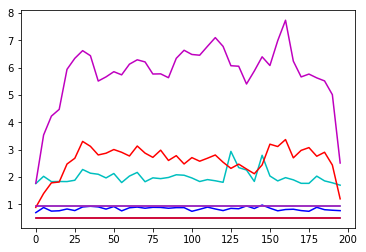

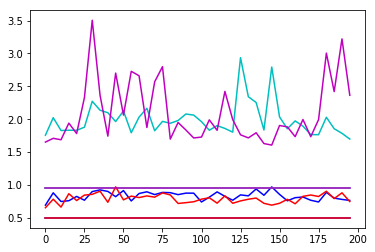

In [92]:
res1 = deployment_example(numUsers=700, weight1=1, weight2=1, serverRange1=range(0, 9), 
                          serverRange2=range(0, 9))
res2 = deployment_example(numUsers=700, weight1=1, weight2=1, serverRange1=range(0, 7), 
                          serverRange2=range(7, 9))
res3 = deployment_example(numUsers=700, weight1=1, weight2=1, serverRange1=range(0, 6),
                          serverRange2=range(6, 9))

# print_results(fi=fi, **res1)
# print_results(fi=fi, **res2)
# print_results(fi=fi, **res3)
compare_simulations(res1, res2)
compare_simulations(res1, res3)

**conclusions**

#### Vary the number of users over time

The list below defines a step function the represents the number of users varying over time.  In this case, the number of users changes every 50 time units.

In [93]:
usersCurve = [(0, 900), (50, 650), (100, 900), (150, 650)]

#### Simulation 5

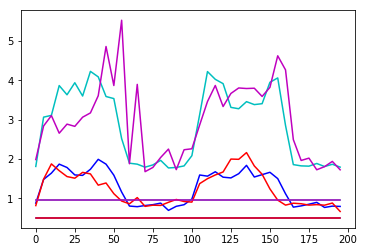

In [94]:
res1 = deployment_example(numUsers=usersCurve, weight1=2, weight2=1, 
                          serverRange1=range(0, 10), serverRange2=range(0, 10))
res2 = deployment_example(numUsers=usersCurve, weight1=2, weight2=1, 
                          serverRange1=range(0, 8), serverRange2=range(8, 10))

# print_results(fi=fi, **res1)
# print_results(fi=fi, **res2)
compare_simulations(res1, res2)

**conclusions**

#### Simulation 6

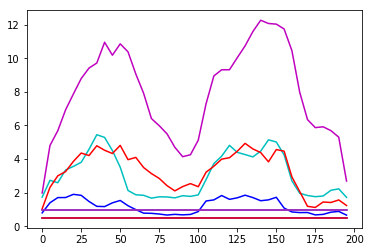

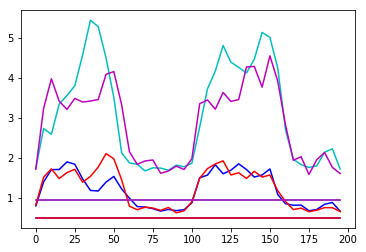

In [95]:
res1 = deployment_example(numUsers=usersCurve, weight1=1, weight2=1, 
                          serverRange1=range(0, 9), serverRange2=range(0, 9))
res2 = deployment_example(numUsers=usersCurve, weight1=1, weight2=1, 
                          serverRange1=range(0, 7), serverRange2=range(7, 9))
res3 = deployment_example(numUsers=usersCurve, weight1=1, weight2=1, 
                          serverRange1=range(0, 6), serverRange2=range(6, 9))

# print_results(fi=fi, **res1)
# print_results(fi=fi, **res2)
# print_results(fi=fi, **res3)
compare_simulations(res1, res2)
compare_simulations(res1, res3)

**conclusions**

#### End of simulations

In [56]:
print("\n*** Done ***", file=fi)

if not fi == sys.stdout:
    fi.close()

**overall conclusions**